# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

2024-12-10 16:51:58.095863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 16:51:58.160897: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 16:51:58.452178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 16:51:58.452232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 16:51:58.509771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Exploratory Data Analysis (EDA)

### Loading data

In [4]:
yfin.pdr_override()

cryptos=['BTC','ETH','SOL','ADA','TRX','FET','INJ']
peso_cryptos=np.ones(len(cryptos))*1/len(cryptos)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(cryptos)):
    cryptos[i]=cryptos[i]+"-USD"

#cryptos.append('-USDT') # inclui o índice ibovespa na ultima coluna

cryptos_df = pd.DataFrame() 
for acao in cryptos:
     cryptos_df[acao] = data.DataReader(acao, start='2017-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(cryptos)):
    cryptos_df = cryptos_df.rename(columns={cryptos[i]:cryptos[i].replace('-USDT', '')})

#renomeia o índice IBOVESPA para IBOV   
#cryptos_df = cryptos_df.rename(columns={cryptos[i]:cryptos[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
cryptos_df.isnull().sum()

#Verifica como está o shape do dataframe
cryptos_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2901, 7)

<Axes: ylabel='Date'>

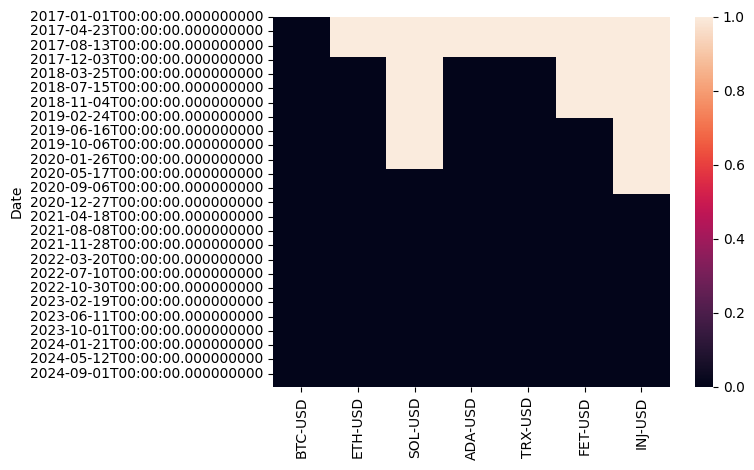

In [5]:
sns.heatmap(cryptos_df.isnull())

In [6]:
#apaga registros nulos
cryptos_df.dropna(inplace=True)
cryptos_df.to_csv('cryptos.csv')
cryptos_df

BTC-USD      ETH-USD     SOL-USD   ADA-USD   TRX-USD  \
Date                                                                     
2020-10-21   12823.689453   392.189972    1.890378  0.106187  0.026721   
2020-10-22   12965.891602   413.772980    1.955653  0.110572  0.027042   
2020-10-23   12931.539062   409.766693    1.960035  0.108083  0.026691   
2020-10-24   13108.062500   412.457611    1.911828  0.108075  0.027050   
2020-10-25   13031.173828   406.217773    1.787459  0.106351  0.026935   
...                   ...          ...         ...       ...       ...   
2024-12-06   99920.710938  4005.810547  237.051071  1.231107  0.325985   
2024-12-07   99923.335938  4002.692627  238.547958  1.214196  0.319312   
2024-12-08  101236.015625  4005.704590  236.672333  1.196291  0.318823   
2024-12-09   97432.718750  3718.690430  217.341461  1.007549  0.263300   
2024-12-10   95680.453125  3615.524658  211.088181  0.956278  0.259461   

             FET-USD    INJ-USD  
Date                             
2020-10-21  0.045765   0.773266  
2020-10-22  0.049113   0.789443  
2020-10-23  0.053041   1.183961  
2020-10-24  0.056407   0.965414  
2020-10-25  0.051211   0.901291  
...              ...        ...  
2024-12-06  2.131475  34.084061  
2024-12-07  2.064109  33.043407  
2024-12-08  2.060343  33.193150  
2024-12-09  1.716155  28.135157  
2024-12-10  1.652797  26.391996  

[1512 rows x 7 columns]

### Visualização dos dados 

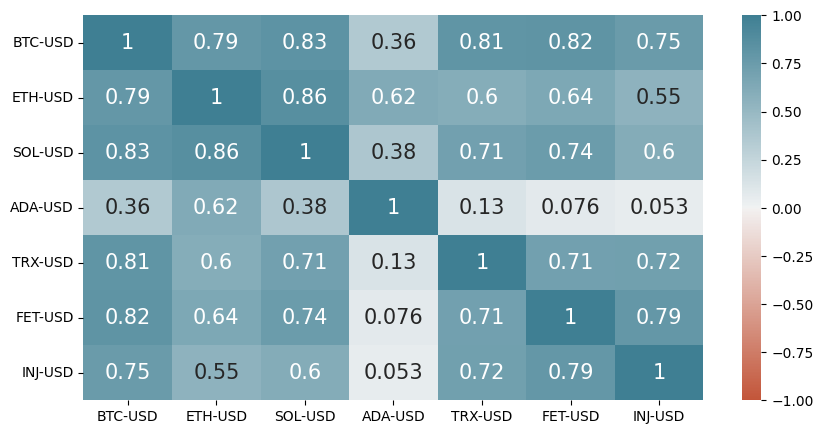

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=cryptos_df.columns
corrmat = cryptos_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [8]:
# Normaliza os dados
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values

In [9]:
cryptos_df_normalized

BTC-USD    ETH-USD     SOL-USD    ADA-USD    TRX-USD    FET-USD  \
Date                                                                           
2020-10-21  1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
2020-10-22  1.011089   1.055032    1.034530   1.041295   1.012013   1.073156   
2020-10-23  1.008410   1.044817    1.036848   1.017855   0.998877   1.158986   
2020-10-24  1.022176   1.051678    1.011347   1.017780   1.012312   1.232536   
2020-10-25  1.016180   1.035768    0.945556   1.001544   1.008009   1.118999   
...              ...        ...         ...        ...        ...        ...   
2024-12-06  7.791885  10.213955  125.398768  11.593764  12.199581  46.574345   
2024-12-07  7.792089  10.206005  126.190613  11.434507  11.949852  45.102350   
2024-12-08  7.894453  10.213684  125.198417  11.265889  11.931552  45.020058   
2024-12-09  7.597869   9.481860  114.972488   9.488441   9.853673  37.499290   
2024-12-10  7.461227   9.218810  111.664535   9.005600   9.709997  36.114863   

              INJ-USD  
Date                   
2020-10-21   1.000000  
2020-10-22   1.020920  
2020-10-23   1.531117  
2020-10-24   1.248489  
2020-10-25   1.165564  
...               ...  
2024-12-06  44.078053  
2024-12-07  42.732264  
2024-12-08  42.925913  
2024-12-09  36.384835  
2024-12-10  34.130552  

[1512 rows x 7 columns]

In [10]:
#%% Carregando dados
cryptos_df=pd.read_csv('cryptos.csv')
cryptos_df['Date']=pd.to_datetime(cryptos_df['Date'])
cryptos_df=cryptos_df.set_index('Date')
for col in cryptos_df.columns:
    cryptos_df[col]=cryptos_df[col].astype('float32')

In [11]:
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values
#cryptos_df_normalized = cryptos_df / cryptos_df.iloc[-1].values

In [12]:
cryptos_df_normalized

BTC-USD    ETH-USD     SOL-USD    ADA-USD    TRX-USD    FET-USD  \
Date                                                                           
2020-10-21  1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
2020-10-22  1.011089   1.055032    1.034530   1.041295   1.012013   1.073156   
2020-10-23  1.008410   1.044817    1.036848   1.017855   0.998877   1.158986   
2020-10-24  1.022176   1.051678    1.011347   1.017780   1.012312   1.232536   
2020-10-25  1.016180   1.035768    0.945556   1.001544   1.008009   1.118999   
...              ...        ...         ...        ...        ...        ...   
2024-12-06  7.791885  10.213955  125.398766  11.593763  12.199581  46.574345   
2024-12-07  7.792089  10.206004  126.190613  11.434506  11.949852  45.102348   
2024-12-08  7.894453  10.213684  125.198418  11.265889  11.931552  45.020058   
2024-12-09  7.597869   9.481860  114.972488   9.488441   9.853673  37.499290   
2024-12-10  7.461226   9.218809  111.664536   9.005600   9.709997  36.114864   

              INJ-USD  
Date                   
2020-10-21   1.000000  
2020-10-22   1.020920  
2020-10-23   1.531117  
2020-10-24   1.248489  
2020-10-25   1.165564  
...               ...  
2024-12-06  44.078053  
2024-12-07  42.732265  
2024-12-08  42.925911  
2024-12-09  36.384834  
2024-12-10  34.130554  

[1512 rows x 7 columns]

In [13]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for cryptos in cryptos_df.columns:
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=cryptos_df_normalized.index, y=cryptos_df_normalized[cryptos], mode='lines', name=f'Preço do {cryptos}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [14]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da crypto
ticker = "BTC"


ticker=ticker+"-USD"

# Obtém os dados históricos da crypto
df = data.DataReader(ticker, start='2017-01-01')



[*********************100%%**********************]  1 of 1 completed


In [15]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [16]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [17]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [18]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'upper_band_bollinger', 'lower_band_bollinger', 'EMA9', 'EMA20',
       'EMA50', 'EMA100', 'EMA200', 'MA111*2', 'MA350*2', 'RSI_14', 'MACD',
       'Signal'],
      dtype='object')

In [19]:
df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04',
               '2024-12-05', '2024-12-06', '2024-12-07', '2024-12-08',
               '2024-12-09', '2024-12-10'],
              dtype='datetime64[ns]', name='Date', length=2901, freq=None)

In [20]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date           Open           High           Low          Close  \
0    2017-01-01     963.658020    1003.080017    958.698975     998.325012   
1    2017-01-02     998.617004    1031.390015    996.702026    1021.750000   
2    2017-01-03    1021.599976    1044.079956   1021.599976    1043.839966   
3    2017-01-04    1044.400024    1159.420044   1044.400024    1154.729980   
4    2017-01-05    1156.729980    1191.099976    910.416992    1013.380005   
...         ...            ...            ...           ...            ...   
2896 2024-12-06   97074.226562  102039.882812  96514.875000   99920.710938   
2897 2024-12-07   99916.710938  100563.382812  99030.882812   99923.335938   
2898 2024-12-08   99921.914062  101399.992188  98771.515625  101236.015625   
2899 2024-12-09  101237.062500  101272.507812  94355.914062   97432.718750   
2900 2024-12-10   97391.328125   98220.039062  94435.835938   95680.453125   

          Adj Close        Volume  upper_band_bollinger  lower_band_bollinger  \
0        998.325012     147775008              0.000000              0.000000   
1       1021.750000     222184992              0.000000              0.000000   
2       1043.839966     185168000              0.000000              0.000000   
3       1154.729980     344945984              0.000000              0.000000   
4       1013.380005     510199008              0.000000              0.000000   
...             ...           ...                   ...                   ...   
2896   99920.710938   94534772658         101523.604861          90017.248264   
2897   99923.335938   44177510897         101591.379922          90957.221641   
2898  101236.015625   44125751925         101842.292027          91775.647035   
2899   97432.718750  110676473908         101640.118094          92486.713937   
2900   95680.453125  121637650432         101576.571186          92684.356939   

              EMA9  ...        MA350*2     RSI_14         MACD       Signal  \
0       998.325012  ...       0.000000   0.000000     0.000000     0.000000   
1      1011.338894  ...       0.000000   0.000000     1.868660     0.373732   
2      1024.659006  ...       0.000000   0.000000     5.073577     1.313701   
3      1068.720989  ...       0.000000   0.000000    16.372661     4.325493   
4      1052.258297  ...       0.000000   0.000000    13.762854     6.212965   
...            ...  ...            ...        ...          ...          ...   
2896  97152.570705  ...  126100.321138  51.828195  4142.594463  4740.874066   
2897  97706.723752  ...  126421.371384  54.465922  4105.846521  4613.868557   
2898  98412.582126  ...  126754.056518  56.417911  4134.980313  4518.090908   
2899  98216.609451  ...  127061.596964  59.023622  3807.286750  4375.930077   
2900  97709.378186  ...  127365.368683  57.501220  3367.377022  4174.219466   

      Variation  Classification  weekday  day  month  quarter  
0      0.000000               0        7    1      1        1  
1      2.292634               1        1    2      1        1  
2      2.116222               1        2    3      1        1  
3      9.603112               1        3    4      1        1  
4    -13.948368              -1        4    5      1        1  
...         ...             ...      ...  ...    ...      ...  
2896   3.329781               1        5    6     12        4  
2897   0.002627               0        6    7     12        4  
2898   1.296653               1        7    8     12        4  
2899  -3.903511              -1        1    9     12        4  
2900  -1.831373              -1        2   10     12        4  

[2901 rows x 25 columns]

## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [21]:
ticker

'BTC-USD'

In [22]:
# Pré-processamento dos dados
cryptos_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
cryptos_df = cryptos_df[['Date', ticker]]
cryptos_df.columns = ['ds', 'y']

In [23]:
# scale the data - normalization
cryptos_df_norm=cryptos_df.copy()
scaler = MinMaxScaler()
cryptos_df_norm['y'] = scaler.fit_transform(cryptos_df['y'].values.reshape(-1,1))

In [24]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
cryptos_df = df[['Close']+features_indicators]  
cryptos_df_normalized = cryptos_df / cryptos_df.max().values
cryptos_df_normalized.describe()
cryptos_df['ds']=df['Date']

/tmp/ipykernel_85895/2694008452.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
[feature.split('_') for feature in features_indicators]

[['EMA9'],
 ['EMA20'],
 ['EMA50'],
 ['EMA100'],
 ['EMA200'],
 ['RSI', '14'],
 ['MACD'],
 ['upper', 'band', 'bollinger'],
 ['lower', 'band', 'bollinger']]

In [26]:
def comput_features(data_array, lookback = 1, features_indicators=[]):
    """_summary_

    Args:
        data_array (_type_): transformed dat in scaler 
        lookback (int, optional): _description_. Defaults to 1.
        features_indicators (list, optional): _description_. Defaults to [].

    Returns:
        _type_: _description_
    """
    #df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])


    if  True in ['bollinger' in feature.split('_') for feature in features_indicators]:
        df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df_)
    # Calcula as EMAs de 9 e 20 períodos
    if 'EMA9' in features_indicators:
        df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    if 'EMA20' in features_indicators:   
        df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    if 'EMA50' in features_indicators: 
        df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    if 'EMA100' in features_indicators: 
        df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    if 'EMA200' in features_indicators: 
        df_['EMA200'] = df_['Close'].ewm(span=200).mean()
    if 'MA111' in features_indicators: 
        df_['MA111'] = df_['Close'].rolling(window=111).mean()
    if 'MA350' in features_indicators: 
        df_['MA350'] = df_['Close'].rolling(window=350).mean() 
    if 'RSI_14' in features_indicators: 
        # Calculate RSI (14-period)
        df_['RSI_14'] = calculate_rsi(df, window=14)
    if 'MACD' in features_indicators: 
        # Calculate MACD (12, 26, 9)
        df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)
    
    df_.iloc[:]= np.nan_to_num(df_.values)
    
    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    #for columns in df_.columns:
    #    df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'MA111', 'MA350',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200', 
                     'MA111', 'MA350',
                     'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]
#features_indicators=[]

In [27]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [28]:
df_norm

Date           Open           High           Low     Close  \
0    2017-01-01     963.658020    1003.080017    958.698975 -0.133752   
1    2017-01-02     998.617004    1031.390015    996.702026 -0.133487   
2    2017-01-03    1021.599976    1044.079956   1021.599976 -0.133238   
3    2017-01-04    1044.400024    1159.420044   1044.400024 -0.131983   
4    2017-01-05    1156.729980    1191.099976    910.416992 -0.133582   
...         ...            ...            ...           ...       ...   
2896 2024-12-06   97074.226562  102039.882812  96514.875000  0.985123   
2897 2024-12-07   99916.710938  100563.382812  99030.882812  0.985153   
2898 2024-12-08   99921.914062  101399.992188  98771.515625  1.000000   
2899 2024-12-09  101237.062500  101272.507812  94355.914062  0.956982   
2900 2024-12-10   97391.328125   98220.039062  94435.835938  0.937163   

          Adj Close        Volume  upper_band_bollinger  lower_band_bollinger  \
0        998.325012     147775008              0.000000              0.000000   
1       1021.750000     222184992              0.000000              0.000000   
2       1043.839966     185168000              0.000000              0.000000   
3       1154.729980     344945984              0.000000              0.000000   
4       1013.380005     510199008              0.000000              0.000000   
...             ...           ...                   ...                   ...   
2896   99920.710938   94534772658         101523.604861          90017.248264   
2897   99923.335938   44177510897         101591.379922          90957.221641   
2898  101236.015625   44125751925         101842.292027          91775.647035   
2899   97432.718750  110676473908         101640.118094          92486.713937   
2900   95680.453125  121637650432         101576.571186          92684.356939   

              EMA9  ...        MA350*2     RSI_14         MACD       Signal  \
0       998.325012  ...       0.000000   0.000000     0.000000     0.000000   
1      1011.338894  ...       0.000000   0.000000     1.868660     0.373732   
2      1024.659006  ...       0.000000   0.000000     5.073577     1.313701   
3      1068.720989  ...       0.000000   0.000000    16.372661     4.325493   
4      1052.258297  ...       0.000000   0.000000    13.762854     6.212965   
...            ...  ...            ...        ...          ...          ...   
2896  97152.570705  ...  126100.321138  51.828195  4142.594463  4740.874066   
2897  97706.723752  ...  126421.371384  54.465922  4105.846521  4613.868557   
2898  98412.582126  ...  126754.056518  56.417911  4134.980313  4518.090908   
2899  98216.609451  ...  127061.596964  59.023622  3807.286750  4375.930077   
2900  97709.378186  ...  127365.368683  57.501220  3367.377022  4174.219466   

      Variation  Classification  weekday  day  month  quarter  
0      0.000000               0        7    1      1        1  
1      2.292634               1        1    2      1        1  
2      2.116222               1        2    3      1        1  
3      9.603112               1        3    4      1        1  
4    -13.948368              -1        4    5      1        1  
...         ...             ...      ...  ...    ...      ...  
2896   3.329781               1        5    6     12        4  
2897   0.002627               0        6    7     12        4  
2898   1.296653               1        7    8     12        4  
2899  -3.903511              -1        1    9     12        4  
2900  -1.831373              -1        2   10     12        4  

[2901 rows x 25 columns]

In [29]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        #X +=[data['Close'].values[win-lookback:win]]
        y += [data[['Close']].values[win:win+pred_days]]
    


    data['Variation'] = ((data['Close'] - data['Close'].shift(+1)) / data['Close'])*100
    #pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y_regression=np.vstack(y)
    return X, y_regression

X, y = windowing(df_norm,features_indicators)
date_time=df_norm['Date'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y regression shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2878, 33)
y regression shape (2878, 1)
Last Date 2024-12-10T00:00:00.000000000


In [30]:
#y=scaler.transform(y)
#for idx in range(len(features_indicators)+ lookback):
#    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [31]:
features_indicators

['EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'upper_band_bollinger',
 'lower_band_bollinger']

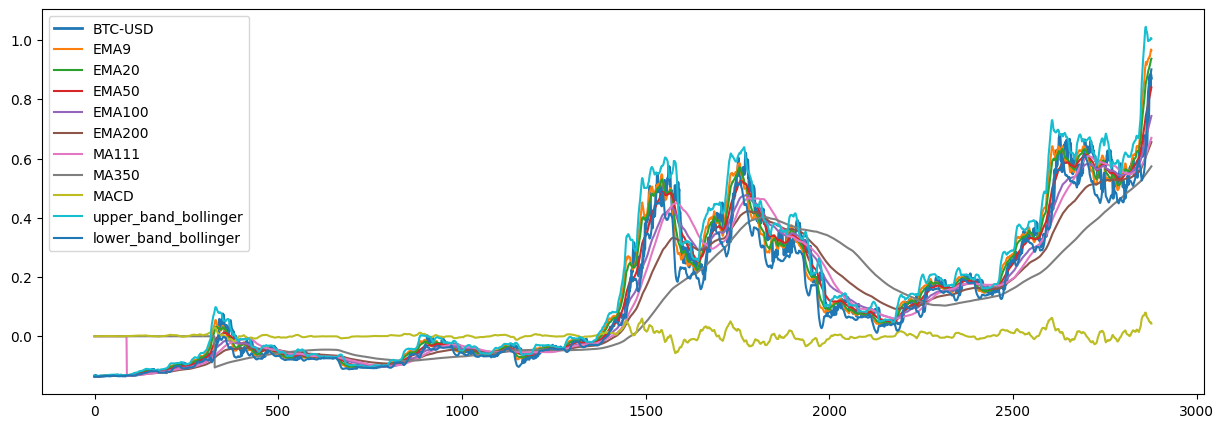

In [32]:
plt.figure(figsize=(15,5))
plt.plot(X[:,0],label=ticker,linewidth=2)
plt.plot(X[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [33]:
# separa os dados em Treino e Teste
def split_data(X : np.array ,y : np.array, date_time : np.datetime64,factor=0.70):
    """Split the data in train validation or test

    Args:
        X (np.array): _description_
        y (np.array): _description_
        date_time (np.datetime64): _description_
        factor (float, optional): _description_. Defaults to 0.70.

    Returns:
        _type_: _description_
    """
    nits=round(len(X)*factor)

    X_train=X[:nits,:]

    nit_test= np.max(X_train.shape) -1
    X_test = X[nit_test:,:]

    y_train =y[:nits]
    y_test =y[nit_test:]

    T_train = date_time[:nits]
    T_test = date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [34]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Neural Networkt aproach

### Used Models

#### CNN_LSTM

In [35]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 batch_normalization (Batch  (None, 15, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 32)                143

2024-12-10 16:52:15.553203: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### MultiLayer Perceptron

In [36]:
# Model name
model_name = "MLP"

# Input layer
input_data = Input(shape=(X.shape[1],))

# Dense layer 1 with batch normalization
dense1 = Dense(64)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)

# Output layer
output = Dense(1, activation='linear')(dropout2)

# Create the model
model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name = model_name

# Print model summary
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2176      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                              

#### Long Short-Term Memory (LSTM) 

In [37]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                              

#### Long Short-Term Memory (GRU) 

In [38]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                               

#### LSTM with Attention layer

In [39]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [40]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 33, 64)            16896     
                                                                 
 batch_normalization_6 (Bat  (None, 33, 64)            256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 33, 64)            0         
                                                                 
 dropout_4 (Dropout)         (None, 33, 64)            0         
                                                                 
 attention (Attention)       (None, 64)                4225      
                                                           

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [41]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [42]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [43]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

Training model : models/model_MLP_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200
49/54 [==========================>...] - ETA: 0s - loss: 0.4632 - NRMSE: 0.4468 
Epoch 1: val_loss improved from inf to 0.00728, saving model to models/model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 16ms/step - loss: 0.4317 - NRMSE: 0.4726 - val_loss: 0.0073 - val_NRMSE: 0.9155 - lr: 0.0500
Epoch 2/200
41/54 [=====================>........] - ETA: 0s - loss: 0.0528 - NRMSE: 0.7874
Epoch 2: val_loss improved from 0.00728 to 0.00477, saving model to models/model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 15ms/step - loss: 0.0456 - NRMSE: 0.8046 - val_loss: 0.0048 - val_NRMSE: 0.9453 - lr: 0.0500
Epoch 3/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0175 - NRMSE: 0.8818
Epoch 3: val_loss did not improve from 0.00477
54/54 [==============================] - 0s 2ms/step - loss: 0.0170 - NRMSE: 0.8834 - val_loss: 0.0109 - val_NRMSE: 0.9162 - lr: 0.0500
Epoch 4/200
54/54 [==============================] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9343
Epoch 4: val_loss did not improve from 0.00477
54/54 [==============================] - 0s 2ms/step - loss: 0.0050 - NRMSE: 0.9343 - val_loss: 0.0227 - val_NRMSE: 0.8759 - lr: 0.0500
Epoch 5/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0083 - NRMSE: 0.9185
Epoch 5: val_loss did not improve from 0.00477
54/54 [==============================] - 0s 2ms/step - loss: 0.0087 - NRMSE: 0.9161 - val_loss: 0.0310 - val_NRMSE: 0.8658 - lr: 0.0500
Epoch 6/200
52/54 [===================

INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 12ms/step - loss: 0.0056 - NRMSE: 0.9310 - val_loss: 0.0038 - val_NRMSE: 0.9485 - lr: 0.0500
Epoch 7/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9356
Epoch 7: val_loss did not improve from 0.00381
54/54 [==============================] - 0s 2ms/step - loss: 0.0052 - NRMSE: 0.9347 - val_loss: 0.0280 - val_NRMSE: 0.8823 - lr: 0.0500
Epoch 8/200
53/54 [============================>.] - ETA: 0s - loss: 0.0080 - NRMSE: 0.9173
Epoch 8: val_loss did not improve from 0.00381
54/54 [==============================] - 0s 2ms/step - loss: 0.0081 - NRMSE: 0.9165 - val_loss: 0.0139 - val_NRMSE: 0.9068 - lr: 0.0500
Epoch 9/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0063 - NRMSE: 0.9268
Epoch 9: val_loss did not improve from 0.00381
54/54 [==============================] - 0s 2ms/step - loss: 0.0063 - NRMSE: 0.9271 - val_loss: 0.0472 - val_NRMSE: 0.8586 - lr: 0.0500
Epoch 10/200
53/54 [==================

INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 12ms/step - loss: 0.0045 - NRMSE: 0.9380 - val_loss: 0.0021 - val_NRMSE: 0.9578 - lr: 0.0500
Epoch 12/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9386
Epoch 12: val_loss did not improve from 0.00215
54/54 [==============================] - 0s 2ms/step - loss: 0.0048 - NRMSE: 0.9356 - val_loss: 0.0210 - val_NRMSE: 0.8869 - lr: 0.0500
Epoch 13/200
54/54 [==============================] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9402
Epoch 13: val_loss did not improve from 0.00215
54/54 [==============================] - 0s 2ms/step - loss: 0.0043 - NRMSE: 0.9402 - val_loss: 0.0142 - val_NRMSE: 0.9026 - lr: 0.0500
Epoch 14/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9368    
Epoch 14: val_loss did not improve from 0.00215
54/54 [==============================] - 0s 2ms/step - loss: 0.0048 - NRMSE: 0.9355 - val_loss: 0.0042 - val_NRMSE: 0.9455 - lr: 0.0500
Epoch 15/200
53/54 [========

INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 12ms/step - loss: 0.0027 - NRMSE: 0.9514 - val_loss: 0.0018 - val_NRMSE: 0.9651 - lr: 0.0500
Epoch 16/200
53/54 [============================>.] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9446
Epoch 16: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 2ms/step - loss: 0.0035 - NRMSE: 0.9440 - val_loss: 0.0170 - val_NRMSE: 0.8962 - lr: 0.0500
Epoch 17/200
53/54 [============================>.] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9391
Epoch 17: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 2ms/step - loss: 0.0044 - NRMSE: 0.9392 - val_loss: 0.0098 - val_NRMSE: 0.9285 - lr: 0.0500
Epoch 18/200
53/54 [============================>.] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9438
Epoch 18: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 2ms/step - loss: 0.0037 - NRMSE: 0.9445 - val_loss: 0.0018 - val_NRMSE: 0.9596 - lr: 0.0500
Epoch 19/200
53/54 [============

INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 13ms/step - loss: 0.0035 - NRMSE: 0.9463 - val_loss: 0.0010 - val_NRMSE: 0.9707 - lr: 0.0100
Epoch 22/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9547
Epoch 22: val_loss improved from 0.00102 to 0.00100, saving model to models/model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 13ms/step - loss: 0.0023 - NRMSE: 0.9556 - val_loss: 0.0010 - val_NRMSE: 0.9738 - lr: 0.0100
Epoch 23/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9604
Epoch 23: val_loss did not improve from 0.00100
54/54 [==============================] - 0s 2ms/step - loss: 0.0017 - NRMSE: 0.9605 - val_loss: 0.0022 - val_NRMSE: 0.9631 - lr: 0.0100
Epoch 24/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9596
Epoch 24: val_loss improved from 0.00100 to 0.00093, saving model to models/model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 18ms/step - loss: 0.0020 - NRMSE: 0.9591 - val_loss: 9.3247e-04 - val_NRMSE: 0.9750 - lr: 0.0100
Epoch 25/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9580
Epoch 25: val_loss did not improve from 0.00093
54/54 [==============================] - 0s 2ms/step - loss: 0.0020 - NRMSE: 0.9585 - val_loss: 0.0022 - val_NRMSE: 0.9618 - lr: 0.0100
Epoch 26/200
49/54 [==========================>...] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9582
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 26: val_loss did not improve from 0.00093
54/54 [==============================] - 0s 2ms/step - loss: 0.0020 - NRMSE: 0.9583 - val_loss: 0.0041 - val_NRMSE: 0.9554 - lr: 0.0100
Epoch 27/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9572    
Epoch 27: val_loss did not improve from 0.00093
54/54 [==============================] - 0s 2ms/step - loss: 0.0022 - NRMSE: 0.957

INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 12ms/step - loss: 0.0016 - NRMSE: 0.9625 - val_loss: 8.8912e-04 - val_NRMSE: 0.9747 - lr: 0.0020
Epoch 29/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9617
Epoch 29: val_loss did not improve from 0.00089
54/54 [==============================] - 0s 2ms/step - loss: 0.0016 - NRMSE: 0.9622 - val_loss: 0.0016 - val_NRMSE: 0.9698 - lr: 0.0020
Epoch 30/200
53/54 [============================>.] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9639    
Epoch 30: val_loss improved from 0.00089 to 0.00076, saving model to models/model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 12ms/step - loss: 0.0015 - NRMSE: 0.9635 - val_loss: 7.6037e-04 - val_NRMSE: 0.9762 - lr: 0.0020
Epoch 31/200
47/54 [=========================>....] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9648    
Epoch 31: val_loss did not improve from 0.00076
54/54 [==============================] - 0s 2ms/step - loss: 0.0016 - NRMSE: 0.9619 - val_loss: 8.4004e-04 - val_NRMSE: 0.9759 - lr: 0.0020
Epoch 32/200
33/54 [=================>............] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9623
Epoch 32: val_loss did not improve from 0.00076
54/54 [==============================] - 0s 2ms/step - loss: 0.0018 - NRMSE: 0.9597 - val_loss: 7.7682e-04 - val_NRMSE: 0.9766 - lr: 0.0020
Epoch 33/200
37/54 [===================>..........] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9608   
Epoch 33: val_loss did not improve from 0.00076
54/54 [==============================] - 0s 3ms/step - loss: 0.0017 - NRMSE: 0.9619 - val_loss: 0.0020 - val_NRMSE: 0.9661 - lr: 0.0020
Epoch 34/200


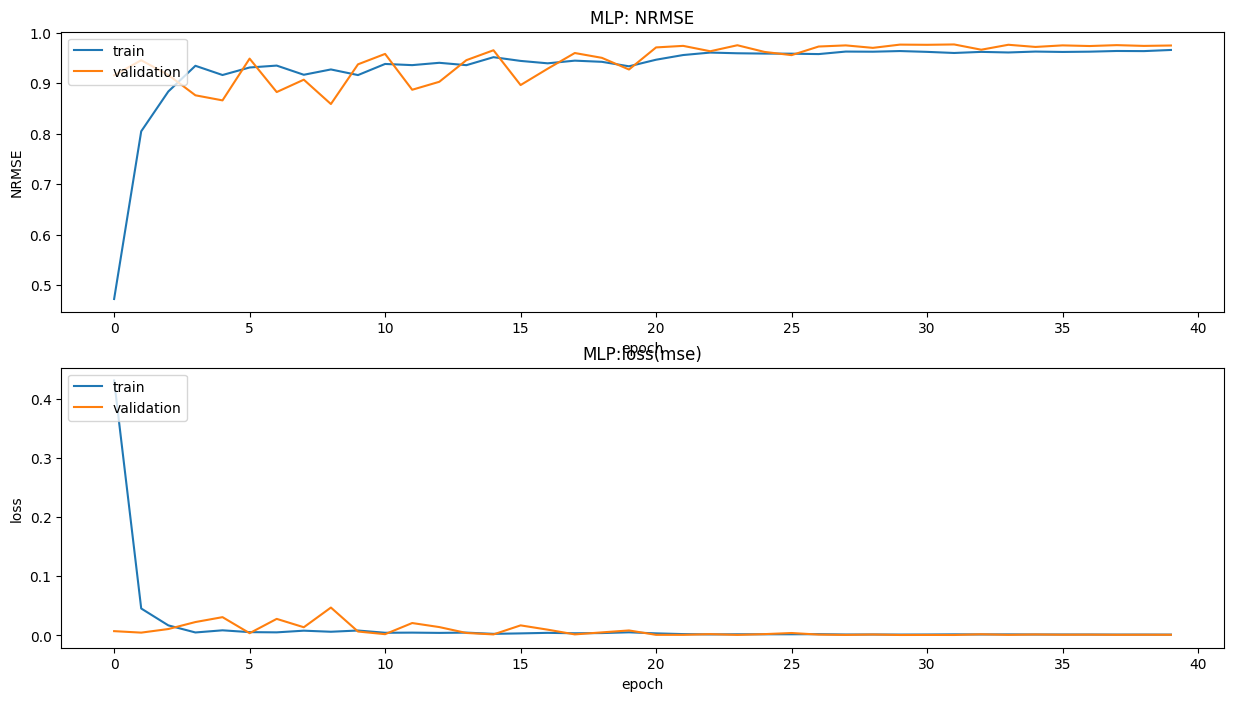

Training model : models/model_GRU_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
46/54 [========================>.....] - ETA: 0s - loss: 0.1088 - NRMSE: 0.8277
Epoch 1: val_loss improved from inf to 0.09198, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 4s 44ms/step - loss: 0.0942 - NRMSE: 0.8427 - val_loss: 0.0920 - val_NRMSE: 0.7267 - lr: 0.0500
Epoch 2/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9388
Epoch 2: val_loss improved from 0.09198 to 0.04628, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 35ms/step - loss: 0.0041 - NRMSE: 0.9398 - val_loss: 0.0463 - val_NRMSE: 0.8278 - lr: 0.0500
Epoch 3/200
54/54 [==============================] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9418
Epoch 3: val_loss improved from 0.04628 to 0.03774, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 34ms/step - loss: 0.0037 - NRMSE: 0.9418 - val_loss: 0.0377 - val_NRMSE: 0.8575 - lr: 0.0500
Epoch 4/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9443
Epoch 4: val_loss improved from 0.03774 to 0.03424, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 39ms/step - loss: 0.0033 - NRMSE: 0.9445 - val_loss: 0.0342 - val_NRMSE: 0.8648 - lr: 0.0500
Epoch 5/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9498
Epoch 5: val_loss improved from 0.03424 to 0.02998, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 33ms/step - loss: 0.0029 - NRMSE: 0.9477 - val_loss: 0.0300 - val_NRMSE: 0.8716 - lr: 0.0500
Epoch 6/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9432
Epoch 6: val_loss did not improve from 0.02998
54/54 [==============================] - 0s 7ms/step - loss: 0.0035 - NRMSE: 0.9440 - val_loss: 0.0344 - val_NRMSE: 0.8526 - lr: 0.0500
Epoch 7/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9471
Epoch 7: val_loss did not improve from 0.02998
54/54 [==============================] - 0s 7ms/step - loss: 0.0036 - NRMSE: 0.9443 - val_loss: 0.0353 - val_NRMSE: 0.8561 - lr: 0.0500
Epoch 8/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9434
Epoch 8: val_loss improved from 0.02998 to 0.01577, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 33ms/step - loss: 0.0035 - NRMSE: 0.9438 - val_loss: 0.0158 - val_NRMSE: 0.9085 - lr: 0.0500
Epoch 9/200
54/54 [==============================] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9477
Epoch 9: val_loss improved from 0.01577 to 0.00732, saving model to models/model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 39ms/step - loss: 0.0031 - NRMSE: 0.9477 - val_loss: 0.0073 - val_NRMSE: 0.9358 - lr: 0.0500
Epoch 10/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9500
Epoch 10: val_loss did not improve from 0.00732
54/54 [==============================] - 0s 8ms/step - loss: 0.0027 - NRMSE: 0.9497 - val_loss: 0.0083 - val_NRMSE: 0.9370 - lr: 0.0500
Epoch 11/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9547
Epoch 11: val_loss did not improve from 0.00732
54/54 [==============================] - 0s 7ms/step - loss: 0.0024 - NRMSE: 0.9533 - val_loss: 0.0097 - val_NRMSE: 0.9277 - lr: 0.0500
Epoch 12/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9492
Epoch 12: val_loss did not improve from 0.00732
54/54 [==============================] - 0s 7ms/step - loss: 0.0029 - NRMSE: 0.9501 - val_loss: 0.0118 - val_NRMSE: 0.9151 - lr: 0.0500
Epoch 13/200
46/54 [============

INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 34ms/step - loss: 0.0040 - NRMSE: 0.9424 - val_loss: 9.6904e-04 - val_NRMSE: 0.9729 - lr: 0.0500
Epoch 14/200
54/54 [==============================] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9501
Epoch 14: val_loss did not improve from 0.00097
54/54 [==============================] - 0s 7ms/step - loss: 0.0027 - NRMSE: 0.9501 - val_loss: 0.0018 - val_NRMSE: 0.9635 - lr: 0.0500
Epoch 15/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9522
Epoch 15: val_loss did not improve from 0.00097
54/54 [==============================] - 0s 8ms/step - loss: 0.0026 - NRMSE: 0.9521 - val_loss: 0.0288 - val_NRMSE: 0.8312 - lr: 0.0500
Epoch 16/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9452
Epoch 16: val_loss did not improve from 0.00097
54/54 [==============================] - 0s 7ms/step - loss: 0.0034 - NRMSE: 0.9457 - val_loss: 0.1619 - val_NRMSE: 0.5998 - lr: 0.0500
Epoch 17/200
46/54 [========

INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 34ms/step - loss: 0.0019 - NRMSE: 0.9595 - val_loss: 8.0981e-04 - val_NRMSE: 0.9753 - lr: 0.0100
Epoch 24/200
54/54 [==============================] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9573
Epoch 24: val_loss did not improve from 0.00081
54/54 [==============================] - 0s 7ms/step - loss: 0.0021 - NRMSE: 0.9573 - val_loss: 0.0051 - val_NRMSE: 0.9326 - lr: 0.0100
Epoch 25/200
54/54 [==============================] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9621
Epoch 25: val_loss did not improve from 0.00081
54/54 [==============================] - 0s 7ms/step - loss: 0.0015 - NRMSE: 0.9621 - val_loss: 0.0011 - val_NRMSE: 0.9706 - lr: 0.0100
Epoch 26/200
53/54 [============================>.] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9631
Epoch 26: val_loss did not improve from 0.00081
54/54 [==============================] - 0s 7ms/step - loss: 0.0015 - NRMSE: 0.9633 - val_loss: 0.0011 - val_NRMSE: 0.9697 - lr: 0.0100
Epoch 27/200
49/54 [========

INFO:tensorflow:Assets written to: models/model_GRU_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 42ms/step - loss: 0.0015 - NRMSE: 0.9621 - val_loss: 6.7780e-04 - val_NRMSE: 0.9766 - lr: 0.0020
Epoch 30/200
53/54 [============================>.] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9616
Epoch 30: val_loss did not improve from 0.00068
54/54 [==============================] - 0s 7ms/step - loss: 0.0017 - NRMSE: 0.9608 - val_loss: 8.4861e-04 - val_NRMSE: 0.9752 - lr: 0.0020
Epoch 31/200
53/54 [============================>.] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9614
Epoch 31: val_loss did not improve from 0.00068
54/54 [==============================] - 0s 7ms/step - loss: 0.0016 - NRMSE: 0.9616 - val_loss: 0.0010 - val_NRMSE: 0.9724 - lr: 0.0020
Epoch 32/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9624
Epoch 32: val_loss did not improve from 0.00068
54/54 [==============================] - 0s 7ms/step - loss: 0.0016 - NRMSE: 0.9616 - val_loss: 0.0020 - val_NRMSE: 0.9583 - lr: 0.0020
Epoch 33/200
46/54 [====

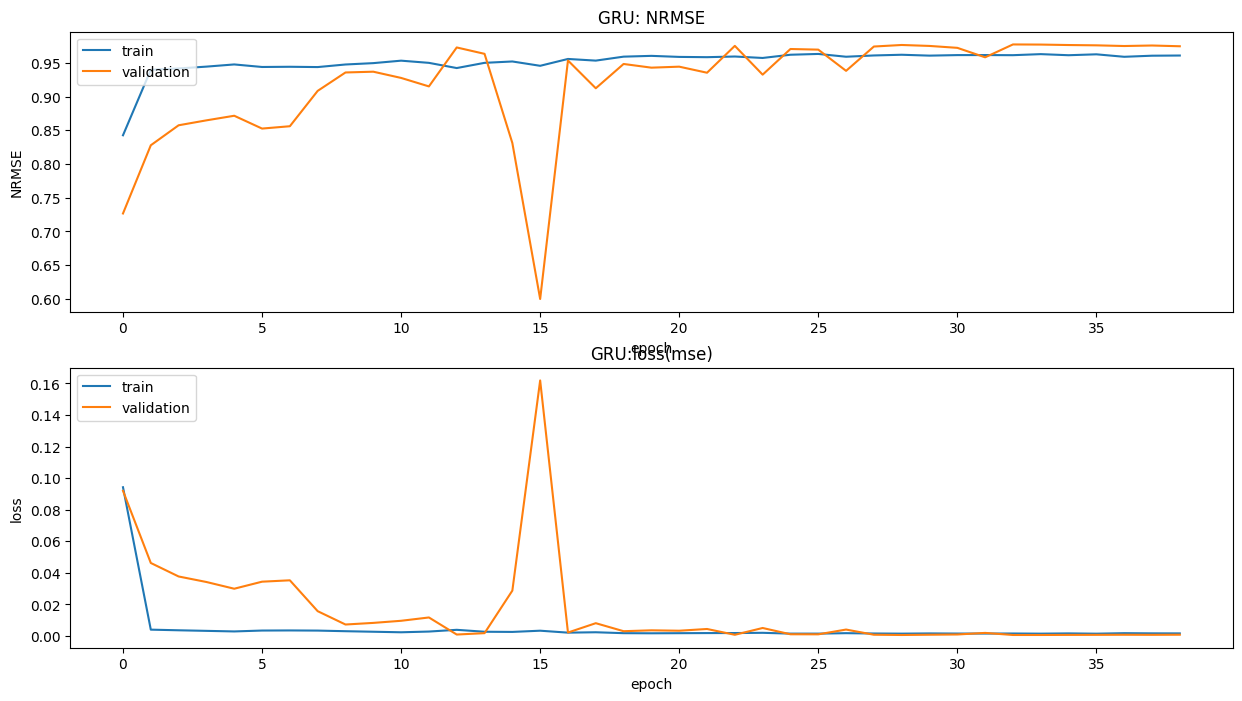

Training model : models/model_CNN_LSTM_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
26/54 [=============>................] - ETA: 0s - loss: 0.3949 - NRMSE: 0.5330  
Epoch 1: val_loss improved from inf to 0.05434, saving model to models/model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 16ms/step - loss: 0.1968 - NRMSE: 0.7295 - val_loss: 0.0543 - val_NRMSE: 0.7906 - lr: 0.0500
Epoch 2/200
31/54 [================>.............] - ETA: 0s - loss: 0.0056 - NRMSE: 0.9329
Epoch 2: val_loss improved from 0.05434 to 0.04005, saving model to models/model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 13ms/step - loss: 0.0055 - NRMSE: 0.9346 - val_loss: 0.0401 - val_NRMSE: 0.8221 - lr: 0.0500
Epoch 3/200
34/54 [=================>............] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9426    
Epoch 3: val_loss improved from 0.04005 to 0.02144, saving model to models/model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 18ms/step - loss: 0.0040 - NRMSE: 0.9427 - val_loss: 0.0214 - val_NRMSE: 0.8703 - lr: 0.0500
Epoch 4/200
31/54 [================>.............] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9477
Epoch 4: val_loss improved from 0.02144 to 0.01250, saving model to models/model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 13ms/step - loss: 0.0037 - NRMSE: 0.9455 - val_loss: 0.0125 - val_NRMSE: 0.9035 - lr: 0.0500
Epoch 5/200
31/54 [================>.............] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9567    
Epoch 5: val_loss improved from 0.01250 to 0.00332, saving model to models/model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 13ms/step - loss: 0.0021 - NRMSE: 0.9586 - val_loss: 0.0033 - val_NRMSE: 0.9529 - lr: 0.0500
Epoch 6/200
31/54 [================>.............] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9575
Epoch 6: val_loss did not improve from 0.00332
54/54 [==============================] - 0s 2ms/step - loss: 0.0022 - NRMSE: 0.9583 - val_loss: 0.0103 - val_NRMSE: 0.9155 - lr: 0.0500
Epoch 7/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9658   
Epoch 7: val_loss did not improve from 0.00332
54/54 [==============================] - 0s 3ms/step - loss: 0.0013 - NRMSE: 0.9652 - val_loss: 0.0124 - val_NRMSE: 0.9117 - lr: 0.0500
Epoch 8/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9502
Epoch 8: val_loss improved from 0.00332 to 0.00091, saving model to models/model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 1s 14ms/step - loss: 0.0029 - NRMSE: 0.9507 - val_loss: 9.1194e-04 - val_NRMSE: 0.9731 - lr: 0.0500
Epoch 9/200
34/54 [=================>............] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9654
Epoch 9: val_loss did not improve from 0.00091
54/54 [==============================] - 0s 2ms/step - loss: 0.0016 - NRMSE: 0.9639 - val_loss: 0.0015 - val_NRMSE: 0.9650 - lr: 0.0500
Epoch 10/200
35/54 [==================>...........] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9593    
Epoch 10: val_loss did not improve from 0.00091
54/54 [==============================] - 0s 2ms/step - loss: 0.0018 - NRMSE: 0.9610 - val_loss: 0.0032 - val_NRMSE: 0.9486 - lr: 0.0500
Epoch 11/200
34/54 [=================>............] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9676
Epoch 11: val_loss did not improve from 0.00091
54/54 [==============================] - 0s 2ms/step - loss: 0.0012 - NRMSE: 0.9669 - val_loss: 0.0017 - val_NRMSE: 0.9624 - lr: 0.0500
Epoch 12/200
34/54 [======

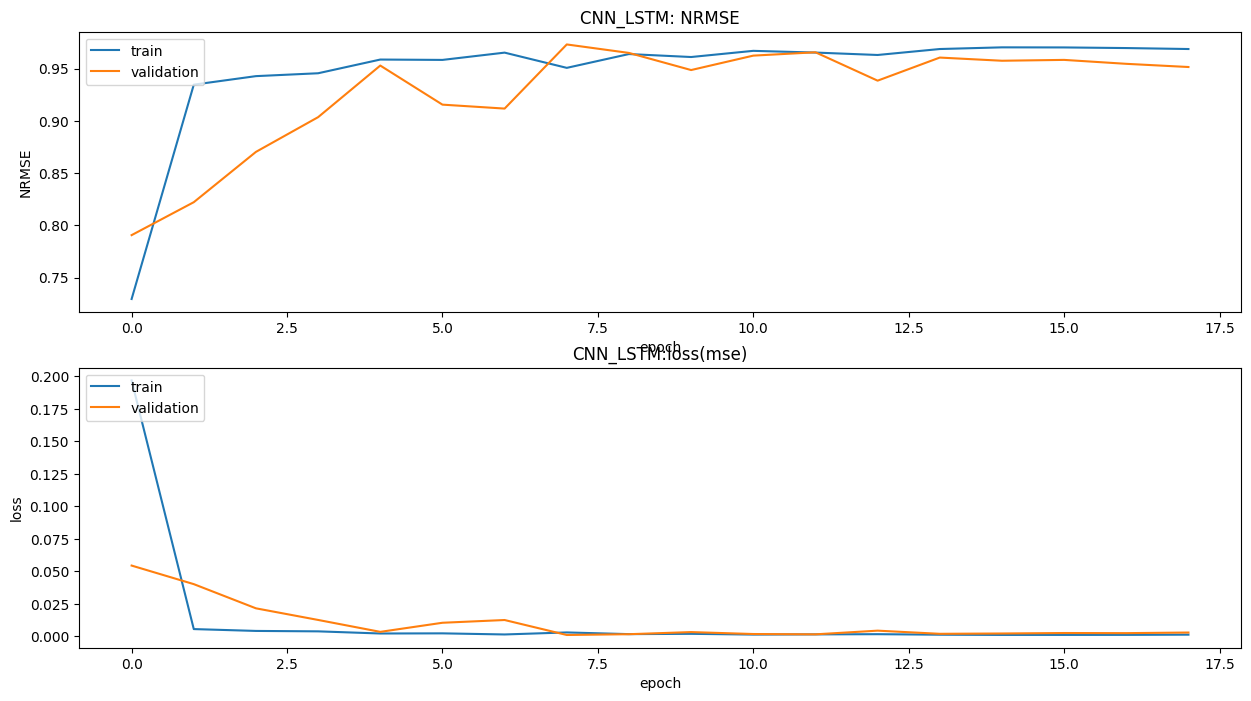

Training model : models/model_LSTM_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
51/54 [===========================>..] - ETA: 0s - loss: 0.1594 - NRMSE: 0.8157
Epoch 1: val_loss improved from inf to 0.04089, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 3s 45ms/step - loss: 0.1524 - NRMSE: 0.8209 - val_loss: 0.0409 - val_NRMSE: 0.8468 - lr: 0.0500
Epoch 2/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0040 - NRMSE: 0.9403
Epoch 2: val_loss improved from 0.04089 to 0.03926, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 35ms/step - loss: 0.0039 - NRMSE: 0.9410 - val_loss: 0.0393 - val_NRMSE: 0.8483 - lr: 0.0500
Epoch 3/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9431
Epoch 3: val_loss improved from 0.03926 to 0.02855, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 36ms/step - loss: 0.0038 - NRMSE: 0.9419 - val_loss: 0.0285 - val_NRMSE: 0.8790 - lr: 0.0500
Epoch 4/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9427
Epoch 4: val_loss improved from 0.02855 to 0.02681, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 43ms/step - loss: 0.0035 - NRMSE: 0.9436 - val_loss: 0.0268 - val_NRMSE: 0.8824 - lr: 0.0500
Epoch 5/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9489
Epoch 5: val_loss did not improve from 0.02681
54/54 [==============================] - 0s 7ms/step - loss: 0.0032 - NRMSE: 0.9451 - val_loss: 0.0278 - val_NRMSE: 0.8775 - lr: 0.0500
Epoch 6/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9442
Epoch 6: val_loss did not improve from 0.02681
54/54 [==============================] - 0s 7ms/step - loss: 0.0033 - NRMSE: 0.9448 - val_loss: 0.0365 - val_NRMSE: 0.8459 - lr: 0.0500
Epoch 7/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9460
Epoch 7: val_loss did not improve from 0.02681
54/54 [==============================] - 0s 8ms/step - loss: 0.0032 - NRMSE: 0.9469 - val_loss: 0.0279 - val_NRMSE: 0.8732 - lr: 0.0500
Epoch 8/200
54/54 [===================

INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 36ms/step - loss: 0.0027 - NRMSE: 0.9506 - val_loss: 0.0193 - val_NRMSE: 0.8975 - lr: 0.0500
Epoch 9/200
54/54 [==============================] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9372
Epoch 9: val_loss improved from 0.01928 to 0.00940, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 39ms/step - loss: 0.0045 - NRMSE: 0.9372 - val_loss: 0.0094 - val_NRMSE: 0.9293 - lr: 0.0500
Epoch 10/200
53/54 [============================>.] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9470
Epoch 10: val_loss did not improve from 0.00940
54/54 [==============================] - 0s 7ms/step - loss: 0.0031 - NRMSE: 0.9472 - val_loss: 0.0201 - val_NRMSE: 0.8737 - lr: 0.0500
Epoch 11/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9489
Epoch 11: val_loss improved from 0.00940 to 0.00507, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 43ms/step - loss: 0.0028 - NRMSE: 0.9494 - val_loss: 0.0051 - val_NRMSE: 0.9471 - lr: 0.0500
Epoch 12/200
54/54 [==============================] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9475
Epoch 12: val_loss did not improve from 0.00507
54/54 [==============================] - 0s 7ms/step - loss: 0.0030 - NRMSE: 0.9475 - val_loss: 0.0943 - val_NRMSE: 0.6957 - lr: 0.0500
Epoch 13/200
53/54 [============================>.] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9512
Epoch 13: val_loss did not improve from 0.00507
54/54 [==============================] - 0s 7ms/step - loss: 0.0027 - NRMSE: 0.9508 - val_loss: 0.0202 - val_NRMSE: 0.8603 - lr: 0.0500
Epoch 14/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9456
Epoch 14: val_loss improved from 0.00507 to 0.00431, saving model to models/model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 37ms/step - loss: 0.0032 - NRMSE: 0.9462 - val_loss: 0.0043 - val_NRMSE: 0.9440 - lr: 0.0500
Epoch 15/200
53/54 [============================>.] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9513
Epoch 15: val_loss did not improve from 0.00431
54/54 [==============================] - 0s 7ms/step - loss: 0.0026 - NRMSE: 0.9514 - val_loss: 0.0251 - val_NRMSE: 0.8507 - lr: 0.0500
Epoch 16/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9527
Epoch 16: val_loss did not improve from 0.00431
54/54 [==============================] - 0s 7ms/step - loss: 0.0027 - NRMSE: 0.9501 - val_loss: 0.0393 - val_NRMSE: 0.8049 - lr: 0.0500
Epoch 17/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9478
Epoch 17: val_loss did not improve from 0.00431
54/54 [==============================] - 0s 7ms/step - loss: 0.0031 - NRMSE: 0.9467 - val_loss: 0.0829 - val_NRMSE: 0.7164 - lr: 0.0500
Epoch 18/200
46/54 [============

INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 42ms/step - loss: 0.0035 - NRMSE: 0.9455 - val_loss: 0.0033 - val_NRMSE: 0.9515 - lr: 0.0500
Epoch 19/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0029 - NRMSE: 0.9493
Epoch 19: val_loss did not improve from 0.00335
54/54 [==============================] - 0s 7ms/step - loss: 0.0029 - NRMSE: 0.9491 - val_loss: 0.0213 - val_NRMSE: 0.8749 - lr: 0.0500
Epoch 20/200
54/54 [==============================] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9480
Epoch 20: val_loss did not improve from 0.00335
54/54 [==============================] - 0s 8ms/step - loss: 0.0031 - NRMSE: 0.9480 - val_loss: 0.0048 - val_NRMSE: 0.9448 - lr: 0.0500
Epoch 21/200
49/54 [==========================>...] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9442
Epoch 21: val_loss did not improve from 0.00335
54/54 [==============================] - 0s 8ms/step - loss: 0.0035 - NRMSE: 0.9437 - val_loss: 0.0232 - val_NRMSE: 0.8551 - lr: 0.0500
Epoch 22/200
54/54 [============

INFO:tensorflow:Assets written to: models/model_LSTM_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 35ms/step - loss: 0.0020 - NRMSE: 0.9568 - val_loss: 8.8444e-04 - val_NRMSE: 0.9732 - lr: 0.0100
Epoch 25/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9555
Epoch 25: val_loss did not improve from 0.00088
54/54 [==============================] - 0s 7ms/step - loss: 0.0020 - NRMSE: 0.9567 - val_loss: 0.0341 - val_NRMSE: 0.8163 - lr: 0.0100
Epoch 26/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9577
Epoch 26: val_loss did not improve from 0.00088
54/54 [==============================] - 0s 7ms/step - loss: 0.0020 - NRMSE: 0.9576 - val_loss: 0.0508 - val_NRMSE: 0.7757 - lr: 0.0100
Epoch 27/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9561
Epoch 27: val_loss did not improve from 0.00088
54/54 [==============================] - 0s 7ms/step - loss: 0.0021 - NRMSE: 0.9565 - val_loss: 0.0168 - val_NRMSE: 0.8716 - lr: 0.0100
Epoch 28/200
45/54 [========

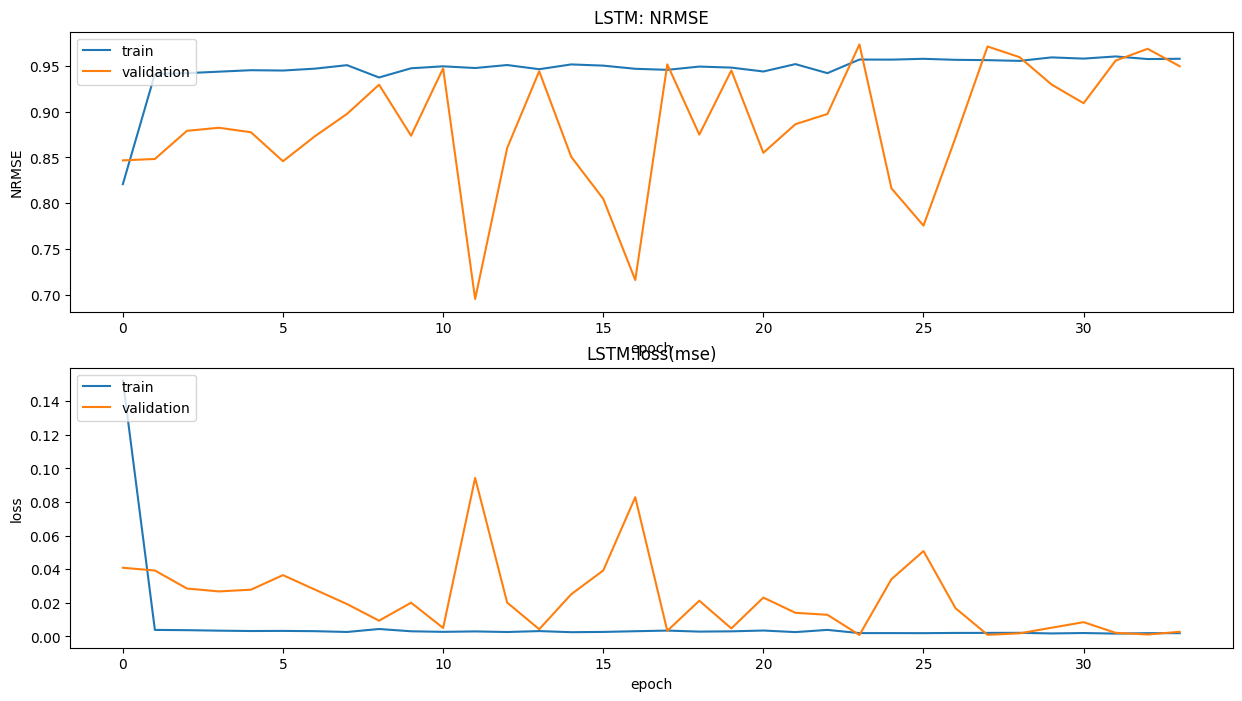

Training model : models/model_LSTM_AT_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
50/54 [==========================>...] - ETA: 0s - loss: 0.2902 - NRMSE: 0.7983
Epoch 1: val_loss improved from inf to 0.03480, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 4s 53ms/step - loss: 0.2715 - NRMSE: 0.8085 - val_loss: 0.0348 - val_NRMSE: 0.8282 - lr: 0.0500
Epoch 2/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9436
Epoch 2: val_loss improved from 0.03480 to 0.01822, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 42ms/step - loss: 0.0036 - NRMSE: 0.9429 - val_loss: 0.0182 - val_NRMSE: 0.9032 - lr: 0.0500
Epoch 3/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9452
Epoch 3: val_loss did not improve from 0.01822
54/54 [==============================] - 0s 9ms/step - loss: 0.0032 - NRMSE: 0.9464 - val_loss: 0.0200 - val_NRMSE: 0.8983 - lr: 0.0500
Epoch 4/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9546
Epoch 4: val_loss did not improve from 0.01822
54/54 [==============================] - 0s 9ms/step - loss: 0.0023 - NRMSE: 0.9543 - val_loss: 0.0301 - val_NRMSE: 0.8770 - lr: 0.0500
Epoch 5/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9487
Epoch 5: val_loss improved from 0.01822 to 0.01005, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 41ms/step - loss: 0.0030 - NRMSE: 0.9482 - val_loss: 0.0100 - val_NRMSE: 0.9178 - lr: 0.0500
Epoch 6/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9426
Epoch 6: val_loss did not improve from 0.01005
54/54 [==============================] - 0s 9ms/step - loss: 0.0036 - NRMSE: 0.9432 - val_loss: 0.0141 - val_NRMSE: 0.9154 - lr: 0.0500
Epoch 7/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9573
Epoch 7: val_loss did not improve from 0.01005
54/54 [==============================] - 0s 9ms/step - loss: 0.0020 - NRMSE: 0.9571 - val_loss: 0.0406 - val_NRMSE: 0.8486 - lr: 0.0500
Epoch 8/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9614
Epoch 8: val_loss did not improve from 0.01005
54/54 [==============================] - 0s 9ms/step - loss: 0.0016 - NRMSE: 0.9614 - val_loss: 0.0483 - val_NRMSE: 0.8247 - lr: 0.0500
Epoch 9/200
50/54 [===================

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 3s 50ms/step - loss: 0.0013 - NRMSE: 0.9653 - val_loss: 0.0038 - val_NRMSE: 0.9439 - lr: 0.0100
Epoch 13/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9661
Epoch 13: val_loss did not improve from 0.00380
54/54 [==============================] - 0s 9ms/step - loss: 0.0013 - NRMSE: 0.9660 - val_loss: 0.0080 - val_NRMSE: 0.9234 - lr: 0.0100
Epoch 14/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9637
Epoch 14: val_loss did not improve from 0.00380
54/54 [==============================] - 1s 10ms/step - loss: 0.0014 - NRMSE: 0.9646 - val_loss: 0.0174 - val_NRMSE: 0.8760 - lr: 0.0100
Epoch 15/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9669
Epoch 15: val_loss did not improve from 0.00380
54/54 [==============================] - 1s 10ms/step - loss: 0.0012 - NRMSE: 0.9668 - val_loss: 0.0191 - val_NRMSE: 0.8788 - lr: 0.0100
Epoch 16/200
49/54 [==========

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 43ms/step - loss: 0.0013 - NRMSE: 0.9665 - val_loss: 0.0022 - val_NRMSE: 0.9623 - lr: 0.0020
Epoch 21/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9672  
Epoch 21: val_loss did not improve from 0.00224
54/54 [==============================] - 1s 10ms/step - loss: 0.0012 - NRMSE: 0.9672 - val_loss: 0.0061 - val_NRMSE: 0.9283 - lr: 0.0020
Epoch 22/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9673
Epoch 22: val_loss did not improve from 0.00224
54/54 [==============================] - 0s 9ms/step - loss: 0.0012 - NRMSE: 0.9674 - val_loss: 0.0032 - val_NRMSE: 0.9524 - lr: 0.0020
Epoch 23/200
53/54 [============================>.] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9691
Epoch 23: val_loss did not improve from 0.00224
54/54 [==============================] - 1s 10ms/step - loss: 0.0010 - NRMSE: 0.9688 - val_loss: 0.0034 - val_NRMSE: 0.9516 - lr: 0.0020
Epoch 24/200
49/54 [========

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 43ms/step - loss: 0.0011 - NRMSE: 0.9678 - val_loss: 0.0018 - val_NRMSE: 0.9649 - lr: 0.0020
Epoch 26/200
50/54 [==========================>...] - ETA: 0s - loss: 9.9525e-04 - NRMSE: 0.9694
Epoch 26: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 9ms/step - loss: 9.7968e-04 - NRMSE: 0.9697 - val_loss: 0.0018 - val_NRMSE: 0.9669 - lr: 0.0020
Epoch 27/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9681 
Epoch 27: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 9ms/step - loss: 0.0012 - NRMSE: 0.9684 - val_loss: 0.0020 - val_NRMSE: 0.9639 - lr: 0.0020
Epoch 28/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9697  
Epoch 28: val_loss did not improve from 0.00176
54/54 [==============================] - 1s 9ms/step - loss: 9.7413e-04 - NRMSE: 0.9703 - val_loss: 0.0028 - val_NRMSE: 0.9553 - lr: 0.0020
Epoch 29/200
50/5

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 3s 50ms/step - loss: 0.0010 - NRMSE: 0.9693 - val_loss: 0.0017 - val_NRMSE: 0.9672 - lr: 4.0000e-04
Epoch 32/200
49/54 [==========================>...] - ETA: 0s - loss: 9.9514e-04 - NRMSE: 0.9697
Epoch 32: val_loss did not improve from 0.00168
54/54 [==============================] - 0s 9ms/step - loss: 9.8785e-04 - NRMSE: 0.9697 - val_loss: 0.0017 - val_NRMSE: 0.9659 - lr: 4.0000e-04
Epoch 33/200
50/54 [==========================>...] - ETA: 0s - loss: 9.0913e-04 - NRMSE: 0.9709
Epoch 33: val_loss improved from 0.00168 to 0.00166, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 42ms/step - loss: 9.1800e-04 - NRMSE: 0.9707 - val_loss: 0.0017 - val_NRMSE: 0.9676 - lr: 4.0000e-04
Epoch 34/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9688   
Epoch 34: val_loss did not improve from 0.00166
54/54 [==============================] - 1s 9ms/step - loss: 0.0010 - NRMSE: 0.9689 - val_loss: 0.0017 - val_NRMSE: 0.9668 - lr: 4.0000e-04
Epoch 35/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9688
Epoch 35: val_loss improved from 0.00166 to 0.00163, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 44ms/step - loss: 0.0011 - NRMSE: 0.9683 - val_loss: 0.0016 - val_NRMSE: 0.9679 - lr: 4.0000e-04
Epoch 36/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9680
Epoch 36: val_loss improved from 0.00163 to 0.00161, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 3s 54ms/step - loss: 0.0011 - NRMSE: 0.9686 - val_loss: 0.0016 - val_NRMSE: 0.9678 - lr: 4.0000e-04
Epoch 37/200
53/54 [============================>.] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9681
Epoch 37: val_loss improved from 0.00161 to 0.00159, saving model to models/model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_BTC-USD_lookback_23/assets


54/54 [==============================] - 2s 43ms/step - loss: 0.0011 - NRMSE: 0.9682 - val_loss: 0.0016 - val_NRMSE: 0.9680 - lr: 4.0000e-04
Epoch 38/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9686  
Epoch 38: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.

Epoch 38: val_loss did not improve from 0.00159
54/54 [==============================] - 1s 10ms/step - loss: 0.0011 - NRMSE: 0.9678 - val_loss: 0.0016 - val_NRMSE: 0.9678 - lr: 4.0000e-04
Epoch 39/200
49/54 [==========================>...] - ETA: 0s - loss: 8.9563e-04 - NRMSE: 0.9708
Epoch 39: val_loss did not improve from 0.00159
54/54 [==============================] - 1s 10ms/step - loss: 9.1588e-04 - NRMSE: 0.9704 - val_loss: 0.0016 - val_NRMSE: 0.9676 - lr: 8.0000e-05
Epoch 40/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9691
Epoch 40: val_loss did not improve from 0.00159
54/54 [==============================] - 1s 10ms/step - loss: 0.00

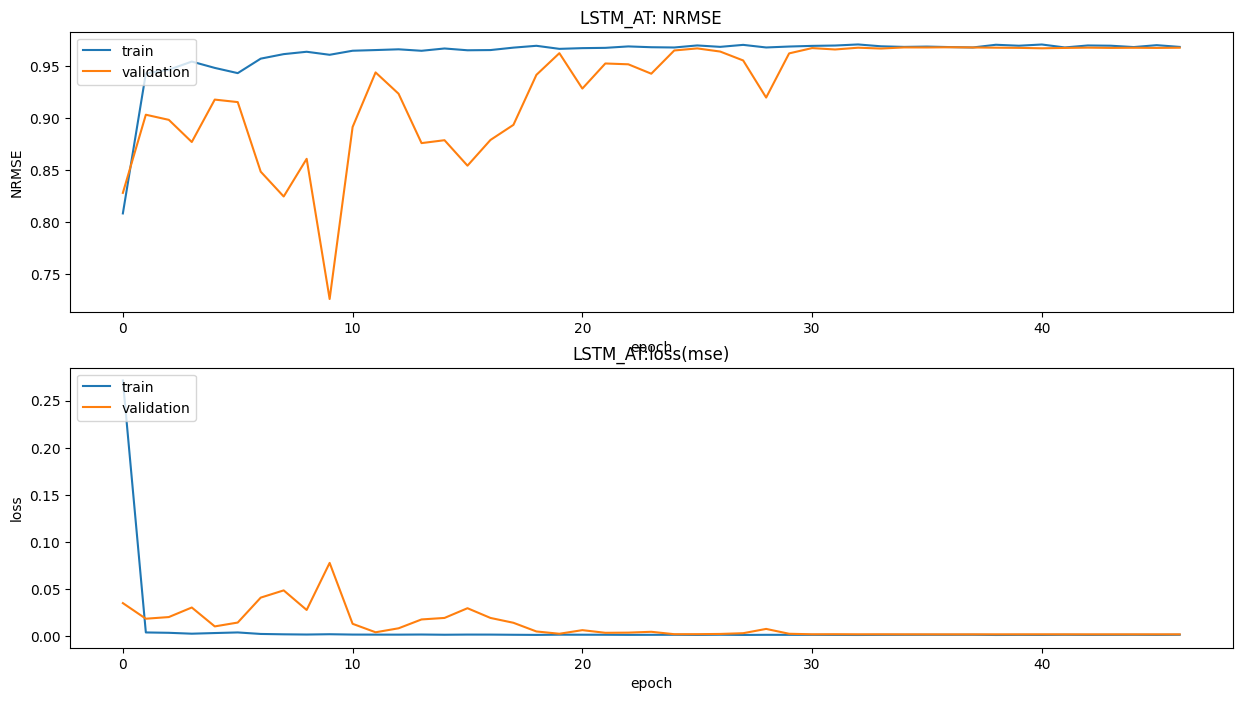

In [44]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [45]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [46]:
checkpoint_filepath

'models/model_LSTM_AT_stock_BTC-USD_lookback_23'

In [47]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x7f05f24744c0>,
 'GRU': <keras.src.engine.functional.Functional at 0x7f05e8430670>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x7f059033ab90>,
 'LSTM': <keras.src.engine.functional.Functional at 0x7f05b02f6620>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x7f05e0589cf0>}

In [48]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(df,features_indicators)

for idx in range(len(features_indicators)+lookback):
    X_real[:,idx]=np.squeeze(scaler.transform(X_real[:,idx].reshape(-1,1)))
#X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

#do the smae split data with the original data to compare 
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

14/14 [==============================] - 0s 781us/step
MLP NN R2: 0.47672292479892886
14/14 [==============================] - 0s 2ms/step
GRU NN R2: 0.901768485049864
14/14 [==============================] - 0s 865us/step
CNN_LSTM NN R2: 0.7030102402504197
14/14 [==============================] - 0s 2ms/step
LSTM NN R2: 0.9410739836242379
14/14 [==============================] - 0s 3ms/step
LSTM_AT NN R2: 0.7267616056547336


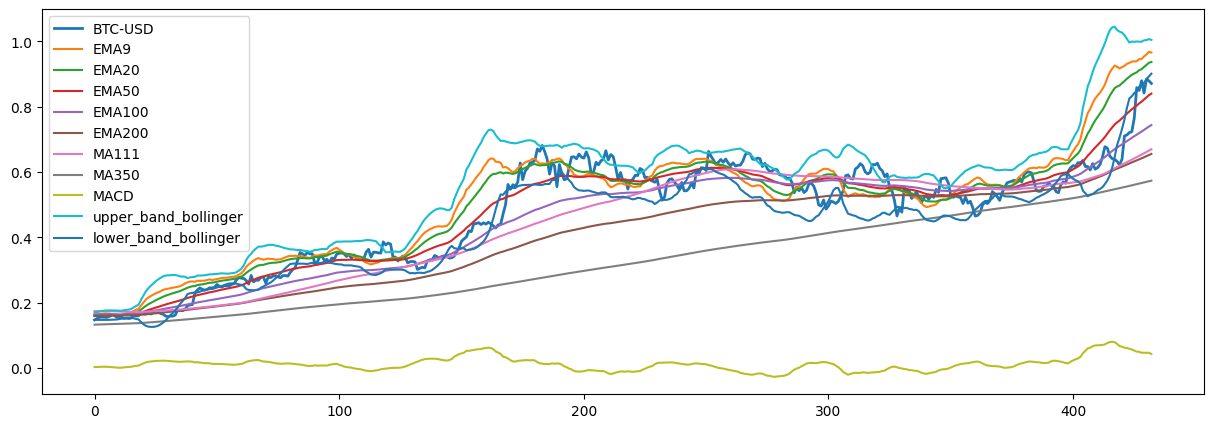

In [49]:
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0],label=ticker,linewidth=2)
plt.plot(X_test[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [50]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [51]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [52]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Get new values to future prediction 

In [53]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-12-10
Estamos Fornecendo dados até o dia : 2024-12-09
O modelo fará previsões até o dia:  2024-12-16


In [64]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test.copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 14ms/step


In [65]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

Using ARIMA model


In [66]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [67]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [68]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

Data           pred   Variacao  Subida
428 2024-12-06   99920.710938   3.329781       1
429 2024-12-07   99923.335938   0.002627       0
430 2024-12-08  101236.015625   1.296653       1
431 2024-12-09   97432.718750  -3.903511       0
432 2024-12-10   95680.453125  -1.831373       0
433 2024-12-11   76226.459281 -25.521314       0
434 2024-12-12   74912.801903  -1.753582       0
435 2024-12-13   73842.102711  -1.449985       0
436 2024-12-16   71657.355073  -3.048881       0
437 2024-12-17   69620.119269  -2.926217       0

In [69]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

Data          pred  Variacao  Subida
432 2024-12-10  95680.453125 -1.831373       0

In [70]:
result=pred_data_df.iloc[-1:,:]
result

Data          pred  Variacao  Subida
437 2024-12-17  69620.119269 -2.926217       0

In [71]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-12-17 é de Descida, de -2.93% o valor predito é de: 69620.12


In [72]:
comput_features(y_test, lookback, features_indicators).reshape(1,-1)

array([[0.87905106, 0.8994232 , 0.92199588, 0.96910735, 0.97468279,
        0.96087948, 0.96355489, 0.90800241, 0.89536869, 0.94035349,
        0.93684649, 0.95730805, 0.94585639, 0.95525252, 0.9392538 ,
        0.94080177, 0.97209115, 0.94749095, 0.98512304, 0.98515273,
        0.99999998, 0.95698226, 0.93716301, 0.96011145, 0.93683425,
        0.84379283, 0.74760929, 0.66477895, 0.67333194, 0.57524777,
        0.03808719, 1.00385188, 0.90327525]])

In [73]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 36ms/step


array([[76226.46]], dtype=float32)